## 뉴욕시의 Taxi 데이터 활용한 예측 모델
    - dataset : 케글의 NYC_Taxi
    - 거리에 따른 택시요금 예측
    - 조건) 뉴욕시 내에서 승차/하차의 경우만
    - 조건 : 뉴욕시 내

##### [1] 데이터 로딩

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# 전체데이터
# file=pd.read_csv('C:/Users/user/Desktop/머신러닝/NYC_Taxi/train.csv')

In [109]:
# nrows = 원하는 행 수 --> 원하는 만큼만 데이터 로딩
# parse_dates = ['컬럼명'] --> 데이터를 가져오면서 datatime으로 형변환
df=pd.read_csv('C:/Users/user/Desktop/머신러닝/NYC_Taxi/train.csv', 
nrows=50000, parse_dates=['pickup_datetime'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB
None


key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [110]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

##### [2] 결측치 및 이상치 체크

In [111]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [112]:
df.describe()
# 요금이 마이너스(-), 승객이 0명?
# 결측치가 없다고 이상치가 없는 것은 아님.

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  50000.000000      50000.000000     50000.000000       50000.000000   
mean      11.364171        -72.509756        39.933759         -72.504616   
std        9.685557         10.393860         6.224857          10.407570   
min       -5.000000        -75.423848       -74.006893         -84.654241   
25%        6.000000        -73.992062        40.734880         -73.991152   
50%        8.500000        -73.981840        40.752678         -73.980082   
75%       12.500000        -73.967148        40.767360         -73.963584   
max      200.000000         40.783472       401.083332          40.851027   

       dropoff_latitude  passenger_count  
count      50000.000000     50000.000000  
mean          39.926251         1.667840  
std            6.014737         1.289195  
min          -74.006377         0.000000  
25%           40.734372         1.000000  
50%           40.753372         1.000000  
75%           40.768167         2.000000  
max           43.415190         6.000000

In [113]:
# 뉴욕으로 한정
df = df[(df["pickup_longitude"] <= -71.47) & (df["pickup_longitude"] >= -79.45)]
df = df[(df["pickup_latitude"] >= 40.29) & (df["pickup_latitude"] <= 45)]
df = df[(df["dropoff_longitude"] <= -71.47) & (df["dropoff_longitude"] >= -79.45)]
df = df[(df["dropoff_latitude"] >= 40.29) & (df["dropoff_latitude"] <= 45)]

##### 결측치 처리

In [114]:
df= df[df['fare_amount'] > 0]
df = df[df['passenger_count'] > 0]

### 특성 새롭게 생성 => 거리(Feature : distance)
- 공식 : $ \sqrt{(x2 - x1)^2 + (y2-y1)^2} $

In [115]:
# distance = ((df.pickup_latitude - df.dropoff_latitude)**2 + (df.pickup_longitude - df.dropoff_latitude)**2)*0.5
df['distance'] = (((df['pickup_longitude'] - df['dropoff_longitude']) ** 2 + (df['pickup_latitude'] - df['dropoff_latitude']) ** 2) ** 0.5) 

df=df[df.distance > 0]

In [116]:
print(df.isnull().sum())
df.describe()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
dtype: int64


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  48255.000000      48255.000000     48255.000000       48255.000000   
mean      11.367828        -73.975478        40.751175         -73.974269   
std        9.559983          0.038775         0.031736           0.037119   
min        0.010000        -75.423848        40.307765         -75.354559   
25%        6.000000        -73.992328        40.736529         -73.991340   
50%        8.500000        -73.982141        40.753467         -73.980515   
75%       12.500000        -73.968515        40.767798         -73.965510   
max      200.000000        -72.856968        43.098708         -72.854940   

       dropoff_latitude  passenger_count      distance  
count      48255.000000     48255.000000  4.825500e+04  
mean          40.751641         1.676158  3.485239e-02  
std            0.034921         1.290360  4.277905e-02  
min           40.316153         1.000000  1.000000e-06  
25%           40.735933         1.000000  1.314358e-02  
50%           40.754148         1.000000  2.210121e-02  
75%           40.768516         2.000000  3.937218e-02  
max           43.415190         6.000000  1.451283e+00

In [117]:
df.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  
0                1  0.009436  
1                1  0.079696  
2                2  0.013674  
3                1  0.025340  
4                1  0.019470

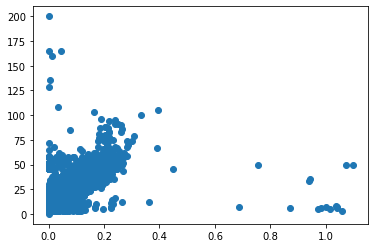

In [126]:
plt.scatter(train_x, train_y)

In [118]:
# 거리(x)에 따른 요금(y)

fare_amount=np.array(df.fare_amount)
distance=np.array(df.distance)

fare_amount=fare_amount.reshape(-1,1)
distance=distance.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(distance, fare_amount, random_state=42, test_size=0.2)

In [125]:
train_poly = np.column_stack((train_x**2, train_x))
test_poly = np.column_stack((test_x**2, test_x))

In [121]:
lr = LinearRegression()
lr.fit(train_poly, train_y)
# print(lr.score(train_x, train_y))
# print(lr.score(test_x, test_y))
print(lr.coef_, lr.intercept_)

[[-237.05841833  258.39167628]] [3.06252802]


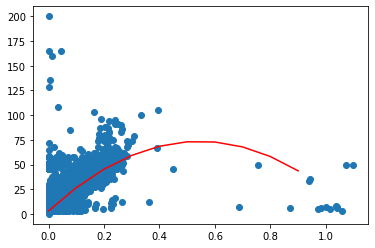

In [133]:
point=np.arange(0.0, 1.0, 0.1)

plt.scatter(train_x, train_y)
plt.plot(point,-237.05841833*point**2 + 258.39167628*point +3.06252802, color='red')

In [136]:
# 이상치 제거
df=df[(df['distance']<0.3) & (df['fare_amount']<100)]

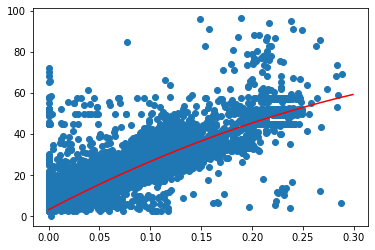

In [139]:
# 제거하고 다시

fare_amount=np.array(df.fare_amount)
distance=np.array(df.distance)

fare_amount=fare_amount.reshape(-1,1)
distance=distance.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(distance, fare_amount, random_state=42, test_size=0.2)

point=np.arange(0, 0.3, 0.001)

plt.scatter(train_x, train_y)
plt.plot(point,-237.05841833*point**2 + 258.39167628*point +3.06252802, color='red')

#### 당뇨